<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/ACF/ACF_and_SARIMAX_for_standardized_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)

In [ ]:
# Convert the date column to a datetime object
df['DT'] = pd.to_datetime(df['DT'], format='%Y-%m-%d')

# Set the date column as the index of the dataframe
df.set_index('DT', inplace=True)
df['ANTAL_01'] = df['ANTAL_01'].astype(int)
df = df.iloc[::-1]

In [ ]:
from sklearn.preprocessing import StandardScaler
from math import sqrt
# prepare data for standardization
values = df.values
print(values)
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
 print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
 print(inversed[i])
df['ANTAL_01'] = normalized
print(df)

[[46084]
 [46026]
 [46108]
 ...
 [30152]
 [30121]
 [30090]]
Mean: 40906.524202, StandardDeviation: 4750.513865
[1.089877]
[1.07766779]
[1.09492908]
[1.07114218]
[1.06251154]
[46084.]
[46026.]
[46108.]
[45995.]
[45954.]
            ANTAL_01
DT                  
2015-12-31  1.089877
2016-01-04  1.077668
2016-01-05  1.094929
2016-01-06  1.071142
2016-01-07  1.062512
...              ...
2022-12-15 -2.236921
2022-12-16 -2.251025
2022-12-19 -2.263865
2022-12-20 -2.270391
2022-12-21 -2.276917

[1818 rows x 1 columns]


In [ ]:
#training and test
training = df.iloc[:-16,:]
print(training.index)
testing = df.iloc[-16:, :]
training.head()

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
               '2022-11-28', '2022-11-29'],
              dtype='datetime64[ns]', name='DT', length=1802, freq=None)


,ANTAL_01
DT,
2015-12-31,1.089877
2016-01-04,1.077668
2016-01-05,1.094929
2016-01-06,1.071142
2016-01-07,1.062512


In [ ]:
# calculate ACF on the whole dataset
acf = sm.tsa.acf(training.dropna(), nlags=len(training)-1)

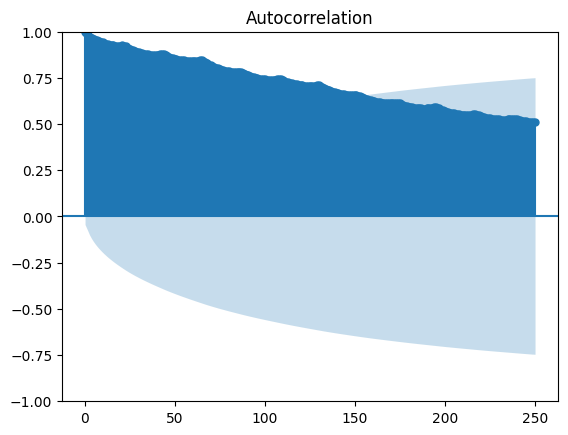

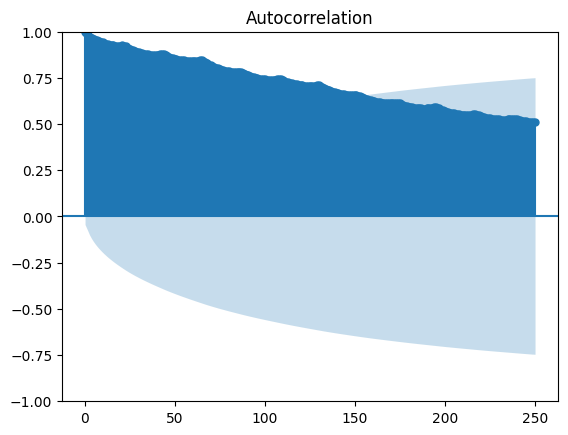

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(training.dropna(), lags = 250) 

In [ ]:
training = training.dropna()
testing = testing.dropna()

In [ ]:
# create a DataFrame with the repeated ACF values as a column
exog = pd.DataFrame({'acf': acf}, index=training.index)

In [ ]:
# drop any rows with missing values from the exog dataframe
exog = exog.dropna()

In [ ]:
np.asarray(training)

array([[ 1.089877  ],
       [ 1.07766779],
       [ 1.09492908],
       ...,
       [-2.0710442 ],
       [-2.07399125],
       [-2.10514578]])

In [ ]:
# fit SARIMAX model with exogenous variable
model = sm.tsa.SARIMAX(training['ANTAL_01'].astype(float), exog=np.asarray(exog), order=(1,1,1), seasonal_order=(1,0,1,22))
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

In [ ]:
exogTest = exog.tail(22)
exogTest2 = exogTest.head(len(testing))
exogTest2
exogvar = np.asarray(exogTest2['acf'])
exogvar = np.asarray(exogTest2['acf'])
# make predictions with the fitted model and exogenous variables for test dataset
test_exog = pd.DataFrame({'acf': exogvar}, index=testing.index)
test_exog

,acf
DT,
2022-11-30,-0.020030
2022-12-01,-0.019679
2022-12-02,-0.019436
2022-12-05,-0.019122
2022-12-06,-0.018554
2022-12-07,-0.017946
2022-12-08,-0.017262
2022-12-09,-0.016536
2022-12-12,-0.015746


In [ ]:
# predict using SARIMAX model
pred = result.predict(start=len(training), end=len(training)+len(testing)-1, exog=test_exog)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


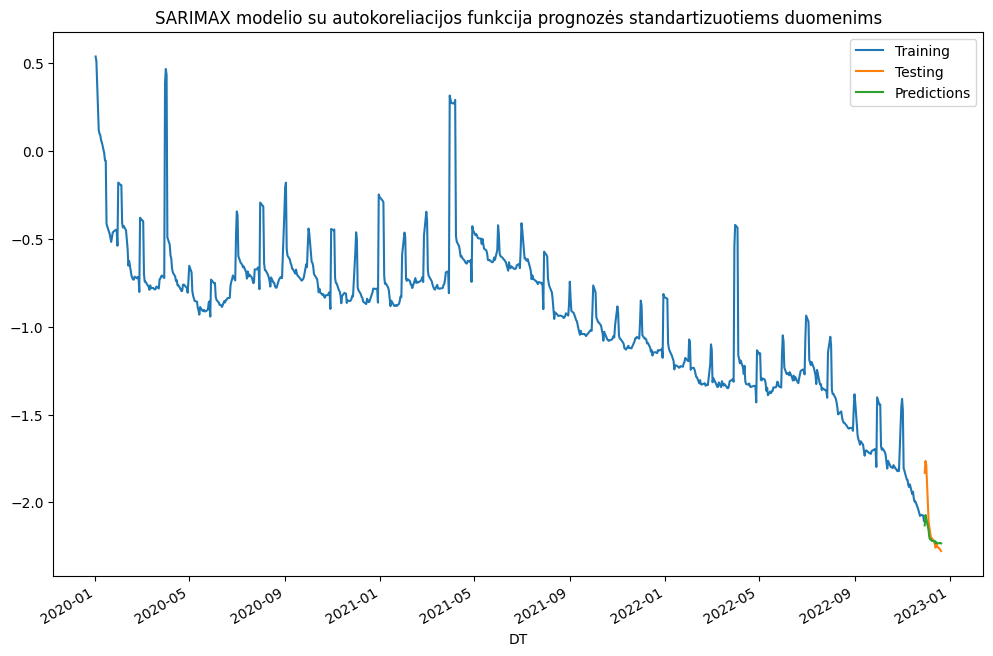

In [ ]:
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
testing['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = testing.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su autokoreliacijos funkcija prognozės standartizuotiems duomenims')
plt.legend()

In [ ]:
predictions = pred

In [ ]:
# inverse transform and print the first 5 rows
normalized_predictions = predictions.values.reshape((len(predictions.values), 1))
print(normalized_predictions)
inversed = scaler.inverse_transform(normalized_predictions)
print(inversed)

[[-2.13083683]
 [-2.07206808]
 [-2.09216013]
 [-2.15886995]
 [-2.20018305]
 [-2.21038728]
 [-2.20954971]
 [-2.21858326]
 [-2.21868229]
 [-2.2199383 ]
 [-2.23259266]
 [-2.22668181]
 [-2.23232083]
 [-2.23242323]
 [-2.23028822]
 [-2.23324325]]
[[30783.95431621]
 [31063.13608023]
 [30967.68849878]
 [30650.78256484]
 [30454.52411403]
 [30406.04880532]
 [30410.02768375]
 [30367.11365187]
 [30366.64323724]
 [30360.67652971]
 [30300.56182104]
 [30328.64139345]
 [30301.85316646]
 [30301.36668292]
 [30311.50907234]
 [30297.47117916]]
